<a href="https://colab.research.google.com/github/linaskerath/comparison-of-ML-up-sell-propensity-models/blob/main/Bakis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **A comparison of machine learning up-sell propensity models for the telecommunication sector**


In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

services = pd.read_csv('/content/drive/My Drive/Bakis/model_data_new.csv')
services = services.drop(['Unnamed: 0', 'contract_end_date'], axis = 1)


In [ ]:
services

,sales20,subscription_prepaid,subscription_postpaid
0,10.80,0,1
1,11.80,0,1
2,10.80,0,1
3,11.80,0,1
4,13.38,0,1
...,...,...,...
1224995,0.00,0,1
1224996,0.00,0,1
1224997,22.88,0,1
1224998,18.39,0,1


In [ ]:
# TEMPORARY
#services['customer_age'].fillna(int(services['customer_age'].median()), inplace=True)
services['delta'] = np.where((services['sales21']-services['sales20'])>0.5, 1, 0)
services = services.drop(['account_id', 'cust_id', 'customer_gender', 'consumption', 'sales21', 'customer_age'], axis=1) 
labels = np.array(services.pop('delta')) 

In [ ]:
services = services.drop(['fix_voice', 'web_tv', 'combination'], axis=1) 

In [ ]:
services=services[['sales20', 'subscription_prepaid' ,	'subscription_postpaid']]

### EDA and feature engineering


In [ ]:
# lookup if there are missing values
services.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1225000 entries, 0 to 1224999
Data columns (total 32 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   account_id             1225000 non-null  object 
 1   cust_id                1225000 non-null  int64  
 2   customer_age           1214071 non-null  float64
 3   customer_gender        1209491 non-null  object 
 4   subscription_prepaid   1225000 non-null  int64  
 5   subscription_postpaid  1225000 non-null  int64  
 6   m_voice                1225000 non-null  int64  
 7   m_data                 1225000 non-null  int64  
 8   adsl                   1225000 non-null  int64  
 9   dth                    1225000 non-null  int64  
 10  fttx                   1225000 non-null  int64  
 11  iptv                   1225000 non-null  int64  
 12  mobix                  1225000 non-null  int64  
 13  vdsl                   1225000 non-null  int64  
 14  web_tv            

In [ ]:
# fill NA age values with median value
services['customer_age'].fillna(int(services['customer_age'].median()), inplace=True)
# fill NA gernder values with previous value 
services['customer_gender'].fillna(method = 'ffill', inplace=True)

# encode gender in binary
services['gender'] = 0
services.loc[services['customer_gender']== 'Male', 'gender'] = 1
services = services.drop(['customer_gender'], axis=1)

In [ ]:
services.isnull().values.any()

False

In [ ]:
# create LABELS - if revenue increased by more than 1ct then 1, else 0.
services['delta'] = np.where((services['sales21']-services['sales20'])>0.5, 1, 0)

# dataset is not perfectly balanced - there are 20% more 1 than 0; ratio is 55:45
print(services['delta'].value_counts())

1    668790
0    556210
Name: delta, dtype: int64


In [ ]:
# overall spending amount of each customer and service percentage of overall
all_sales = services.groupby('cust_id')['sales20'].sum().reset_index()
all_sales = all_sales.rename(columns = {'sales20': 'all_sales'}, inplace = False)
services = pd.merge(services,all_sales,on='cust_id',how='left')
services['sales_percentage'] = services['sales20'] / services['all_sales']
services['sales_percentage'] = services['sales_percentage'].fillna(0)
services = services.drop(['sales21'], axis=1)

### Exploratory data analysis

In [ ]:
for column in services.columns[3:27]:
  print(f'{column} : {services[column].sum()}')

for column in services.columns[29:-2]:
  print(f'{column} : {services[column].sum()}')
# all : 1 225 000
# fix_voice,web_tv can be dropped 

subscription_prepaid : 236727
subscription_postpaid : 988273
m_voice : 770582
m_data : 55073
adsl : 24888
dth : 79609
fttx : 112201
iptv : 105303
mobix : 20211
vdsl : 13963
web_tv : 404
fix_voice : 0
tv_c : 672013
bb_c : 668134
iptv_c : 384120
dth_c : 287893
fttx_c : 416456
adsl_c : 99330
mobix_c : 95336
vdsl_c : 57012
voice_c : 1665360
data_c : 332675
fixed_voice_c : 220689
prepaid_c : 493046
combination : 503985
gender : 652745
delta : 668790


In [ ]:
services = services.drop(['fix_voice', 'web_tv'], axis=1)

In [ ]:
# observe if necessary to encode
# difficult to rank so better one-hot
services['consumption'].value_counts()

0                                   399345
underusing_voice_underusing_data    200703
underusing_voice_right_data         195664
overusing_voice_right_data          123809
underusing_voice_overusing_data      88482
right_voice_right_data               75951
overusing_voice_overusing_data       59217
right_voice_underusing_data          56564
right_voice_overusing_data           22989
overusing_voice_underusing_data       2276
Name: consumption, dtype: int64

In [ ]:
# one-hot-encode consumption 
services = pd.concat([services, pd.get_dummies(services['consumption'], dtype=np.int64)], axis=1)
services = services.drop(['consumption'], axis=1)

In [ ]:
services['sales20'].value_counts(ascending = True, bins = 10)
# these outliers might harm models like nn


(1416.312, 1652.364]          0
(1888.416, 2124.468]          0
(944.208, 1180.26]            1
(1652.364, 1888.416]          1
(2124.468, 2360.52]           1
(708.156, 944.208]            2
(1180.26, 1416.312]           2
(472.104, 708.156]           10
(236.052, 472.104]           88
(-2.362, 236.052]       1224895
Name: sales20, dtype: int64

In [ ]:
services = services.loc[services['sales20']<240] # 100 highest are removed

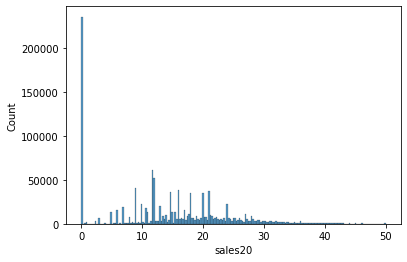

In [ ]:
sns.histplot(data=services.loc[services['sales20']<50] , x="sales20") # most are under 50.

In [ ]:
services['service_count'] = (services['tv_c']+services['bb_c']+services['iptv_c']
                             +services['dth_c']+services['fttx_c']+services['adsl_c']
                             +services['mobix_c']+services['vdsl_c']+services['voice_c']
                             +services['data_c']+services['fixed_voice_c']+services['prepaid_c'])

In [ ]:
services[['service_count', 'combination','customer_age', 'sales20', 'all_sales', 'sales_percentage']].corr() #services.corr()
# nothing surprising here #services.corr()

,service_count,combination,customer_age,sales20,all_sales,sales_percentage
service_count,1.000000,0.389203,-0.023332,0.110755,0.584491,-0.269543
combination,0.389203,1.000000,0.067909,0.086030,0.324893,-0.146390
customer_age,-0.023332,0.067909,1.000000,-0.156709,-0.105546,-0.065846
sales20,0.110755,0.086030,-0.156709,1.000000,0.492826,0.531882
all_sales,0.584491,0.324893,-0.105546,0.492826,1.000000,-0.161637
sales_percentage,-0.269543,-0.146390,-0.065846,0.531882,-0.161637,1.000000


In [ ]:
services[['customer_age','sales20', 'all_sales', 'sales_percentage']].describe()

,customer_age,sales20,all_sales,sales_percentage
count,1.224901e+06,1.224901e+06,1.224901e+06,1.224901e+06
mean,4.982046e+01,1.488824e+01,3.657945e+01,4.578580e-01
std,1.437562e+01,1.184467e+01,3.176562e+01,3.622469e-01
min,1.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.900000e+01,7.980000e+00,1.642000e+01,1.668727e-01
50%,4.900000e+01,1.480000e+01,3.002000e+01,3.915362e-01
75%,6.000000e+01,2.099000e+01,5.058000e+01,7.736626e-01
max,2.510000e+02,2.397300e+02,2.402100e+03,1.000000e+00


In [ ]:
# change all over 100 to 100 because if their old, it won't make much difference, but it might break model.
services.loc[(services.customer_age >100),'customer_age']= 100

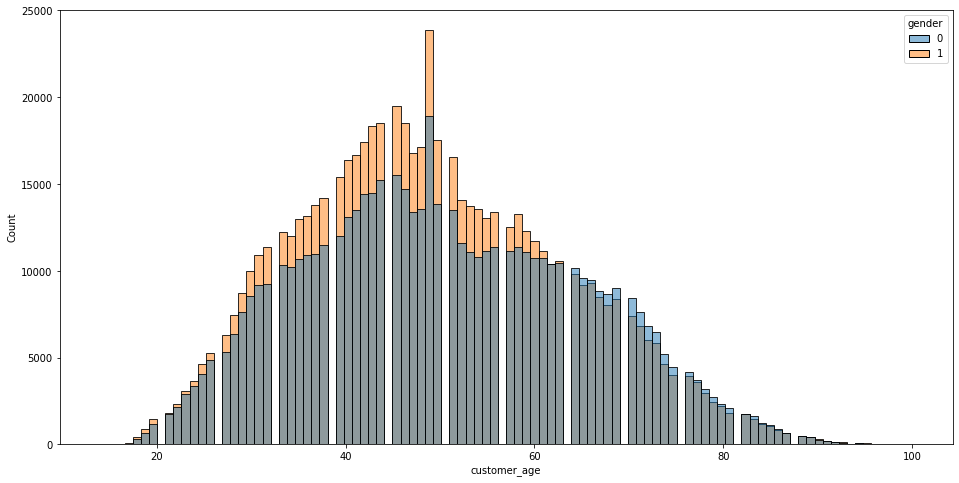

In [ ]:
plt.figure(figsize=(16,8)) # much more male customers; normal distribution
sns.histplot(x ='customer_age', data = services, hue='gender', bins = 100)

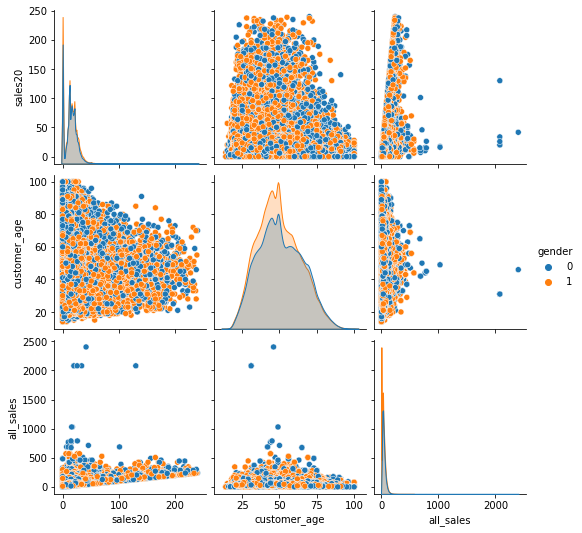

In [ ]:
sns.pairplot(services ,vars = ['sales20', 'customer_age', 'all_sales'], hue='gender')

In [ ]:
# univariate and bivariate analysis?

### Egles?

In [ ]:
# categirization
services['temp_iptv'] = np.where(services['iptv_c'] > 0, 1, 0)
services['temp_dth'] = np.where(services['dth_c'] > 0, 1, 0)
services['temp_fttx'] = np.where(services['fttx_c'] > 0, 1, 0)
services['temp_adsl'] = np.where(services['adsl_c'] > 0, 1, 0)
services['temp_mobix'] = np.where(services['mobix_c'] > 0, 1, 0)
services['temp_vdsl'] = np.where(services['vdsl_c'] > 0, 1, 0)
services['temp_voice'] = np.where(services['voice_c'] > 0, 1, 0)
services['temp_data'] = np.where(services['data_c'] > 0, 1, 0)

In [ ]:
# fix&mobile
services['has_fix_n_mobile'] =\
np.where(
  (
    (services['temp_iptv']
          | services['temp_dth']
    )|
    (services['temp_fttx']
          | services['temp_adsl']
          | services['temp_mobix'] # temp_mobix idetas fixe
          | services['temp_vdsl']
    )
  )+
    (services['temp_voice']
          | services['temp_data']
    )
  > 1, 1, 0
)

# mobile
services['has_mobile'] =\
np.where((
  (
    (services['temp_voice']+ services['temp_data'])>1
  )
  &
  (
      (services['temp_iptv']+ services['temp_dth']+services['temp_fttx'] +services['temp_adsl']+ services['temp_vdsl']+ services['temp_mobix'])==0 
  )

), 1, 0)

# fix
services['has_fix'] =\
np.where((
  (
    (services['temp_voice']+ services['temp_data'])==0
  )
  &
  (
      ((services['temp_iptv']| services['temp_dth'])+(services['temp_fttx'] | services['temp_adsl']| services['temp_vdsl']| services['temp_mobix'])> 1)
      |((services['temp_iptv']+ services['temp_dth'])>1) # tik  tv
      |((services['temp_fttx']+ services['temp_adsl']+ services['temp_vdsl'] + services['temp_mobix'])> 1) # tik bb 
  
  )

), 1, 0)

# single
services['is_single'] =\
np.where(services['temp_iptv']\
          + services['temp_dth']\
          + services['temp_fttx']\
          + services['temp_adsl']\
          + services['temp_mobix']\
          + services['temp_vdsl']\
          + services['temp_voice']\
          + services['temp_data'] == 1, 1, 0)

# nothing
services['has_nothing'] =\
np.where(services['temp_iptv']\
          + services['temp_dth']\
          + services['temp_fttx']\
          + services['temp_adsl']\
          + services['temp_mobix']\
          + services['temp_vdsl']\
          + services['temp_voice']\
          + services['temp_data'] == 0, 1, 0)          

# multiple
services['has_multiple'] =\
np.where(services['temp_iptv']\
          + services['temp_dth']\
          + services['temp_fttx']\
          + services['temp_adsl']\
          + services['temp_mobix']\
          + services['temp_vdsl']\
          + services['temp_voice']\
          + services['temp_data'] > 1, 1, 0)


In [ ]:
services = services.drop(['temp_iptv', 'temp_dth','temp_fttx', 'temp_adsl','temp_mobix', 'temp_vdsl',  'temp_voice','temp_data'  ], axis=1)

### Train-test split and data scaling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

In [ ]:
# # temp
# services = services.drop(['consumption'], axis=1)

# # drop labels from df and put into array
# labels = np.array(services.pop('delta')) 

In [ ]:
# # safe personal information to match after prediction
# train_acc_id = np.array(train.pop('account_id')) 
# train_cust_id = np.array(train.pop('cust_id')) 
# test_acc_id = np.array(test.pop('account_id')) 
# test_cust_id = np.array(test.pop('cust_id')) 

# # safe personal information to match after prediction
# train_acc_id = np.array(train.pop('account_id')) 
# train_cust_id = np.array(train.pop('cust_id')) 
# test_acc_id = np.array(test.pop('account_id')) 
# test_cust_id = np.array(test.pop('cust_id')) 


# fix this later!!!!

In [ ]:
scaler = MinMaxScaler()
services_scaled = scaler.fit_transform(services)

In [ ]:
# unscaled
train, test, train_labels, test_labels = train_test_split(services, labels, test_size=0.25, random_state=50)

In [ ]:
# scaled
train_scaled, test_scaled, train_labels, test_labels = train_test_split(services_scaled, labels, test_size=0.25, random_state=50)

### Decision Tree

In [ ]:
# IMPORT
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [ ]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()#(criterion = 'entropy', max_depth=16) 

# Train Decision Tree Classifer
clf = clf.fit(train, train_labels)

In [ ]:
#Predict the response for test dataset
y_pred = clf.predict(test)
y_pred_prob = clf.predict_proba(test)

#### Validation

accuracy, n-fold cross-validation, 

grid- search optimization ? https://stackoverflow.com/questions/63046906/how-to-best-determine-the-accuracy-of-a-model-repeated-train-test-splits-or-cv

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_labels, y_pred))


Accuracy: 0.7667330612244898


In [ ]:
# kazkas cia atsitinka, kad is 0.7185281458791872 -> Accuracy: 0.7210938775510204 -> Accuracy: 0.7367575510204082 no preproc

In [ ]:
#Making the Confusion Matrix
cm = confusion_matrix(test_labels, y_pred)

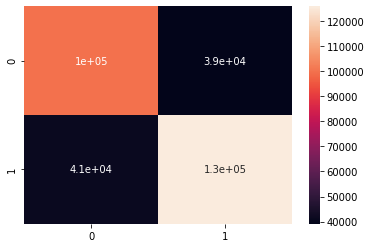

In [ ]:
sns.heatmap(cm, annot=True)

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = metrics.accuracy_score(test_labels, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = metrics.precision_score(test_labels, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = metrics.recall_score(test_labels, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = metrics.f1_score(test_labels, y_pred)
print('F1 score: %f' % f1)

# ROC AUC
auc = metrics.roc_auc_score(test_labels, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(test_labels, y_pred)
print(matrix)

Accuracy: 0.786011
Precision: 0.753241
Recall: 0.903542
F1 score: 0.821574
ROC AUC: 0.774314
[[ 89838  49427]
 [ 16107 150878]]


*Laba, 

šiandien klausiau tavo pristatymą ir man užkibo pora vietų, tad surašiau tau pastabas, kurios galbūt bus naudingos :

Random Forest gražina score, o ne probability, tad siūlyčiau neinterpretuoti kaip probability. Geresnis būdas matavimui yra suskaidyti savo baze percentilėmis ar decilėmis pagal score didejimo tvarka ir žiūrėti kaip tiksliai pataikai kiekvienoje grupeje.


Matuojant modeli svarbu atsizvelgti i ne viena KPI: ROC kreive, Accuracy, Precision, Recall, Lift. Pasidaryti Confusion matricas.*



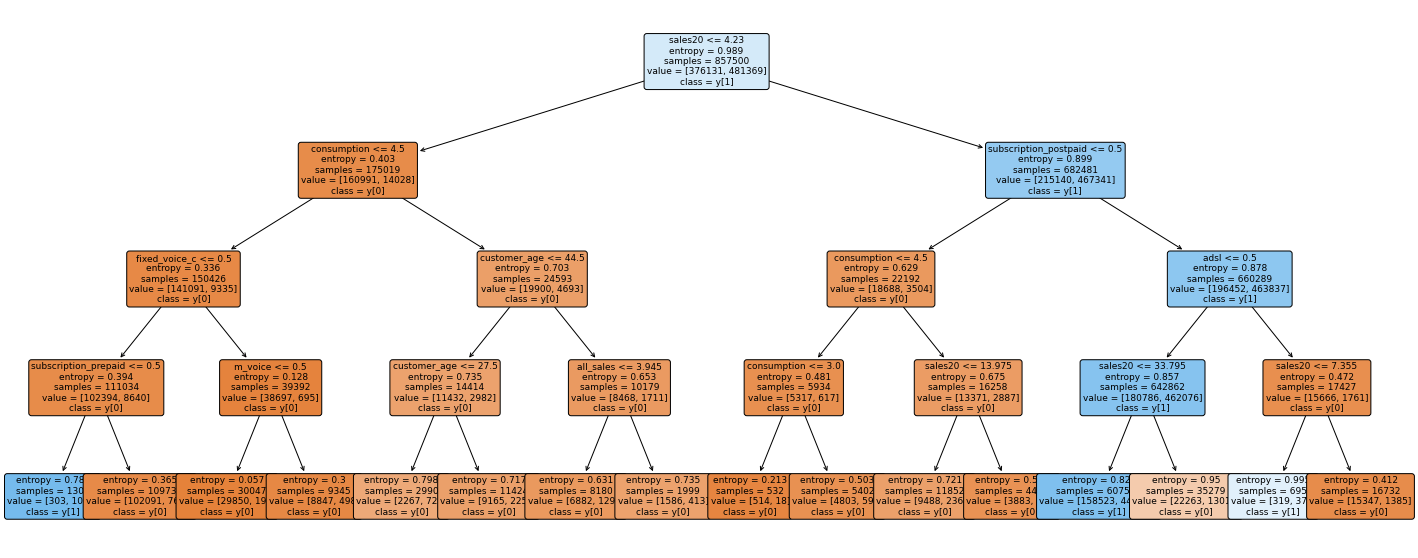

In [ ]:
plt.figure(figsize=(25,10))
plot_tree(clf, filled=True,  rounded=True, fontsize=9, feature_names=list(train.columns), class_names= True);

### XGBoost

In [ ]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# fit model no training data
XGB_model = XGBClassifier()
XGB_model.fit(train, train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# make predictions for test data
y_pred = XGB_model.predict(test)
predictions = [round(value) for value in y_pred]

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = metrics.accuracy_score(test_labels, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = metrics.precision_score(test_labels, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = metrics.recall_score(test_labels, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = metrics.f1_score(test_labels, y_pred)
print('F1 score: %f' % f1)

# ROC AUC
auc = metrics.roc_auc_score(test_labels, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(test_labels, y_pred)
print(matrix)

Accuracy: 0.780506
Precision: 0.738129
Recall: 0.925957
F1 score: 0.821443
ROC AUC: 0.766030
[[ 84409  54856]
 [ 12364 154621]]


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

In [ ]:
model = model.fit(train, train_labels)

In [ ]:
#Predict the response for test dataset
y_pred = model.predict(test)

y_pred_prob = model.predict_proba(test)

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = metrics.accuracy_score(test_labels, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = metrics.precision_score(test_labels, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = metrics.recall_score(test_labels, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = metrics.f1_score(test_labels, y_pred)
print('F1 score: %f' % f1)

# ROC AUC
auc = metrics.roc_auc_score(test_labels, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(test_labels, y_pred)
print(matrix)

Accuracy: 0.776826
Precision: 0.761756
Recall: 0.859520
F1 score: 0.807690
ROC AUC: 0.768596
[[ 94376  44889]
 [ 23458 143527]]


In [ ]:
feature_list = list(train.columns)
importances = list(model.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('{:} Importance: {}'.format(*pair)) for pair in feature_importances]

sales20 Importance: 0.53
subscription_prepaid Importance: 0.11
subscription_postpaid Importance: 0.07
voice_c Importance: 0.06
prepaid_c Importance: 0.04
m_voice Importance: 0.03
adsl Importance: 0.02
data_c Importance: 0.02
m_data Importance: 0.01
dth Importance: 0.01
fttx Importance: 0.01
iptv Importance: 0.01
mobix Importance: 0.01
vdsl Importance: 0.01
tv_c Importance: 0.01
bb_c Importance: 0.01
iptv_c Importance: 0.01
fttx_c Importance: 0.01
adsl_c Importance: 0.01
fixed_voice_c Importance: 0.01
dth_c Importance: 0.0
mobix_c Importance: 0.0
vdsl_c Importance: 0.0


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

### Support Vector Machine

In [ ]:
train_PCA = train[['sales20',
 'customer_age',
 'all_sales',
 'sales_percentage'
#  'subscription_postpaid',
#  'voice_c',
#  'subscription_prepaid',
#  'consumption',
#  'm_voice',
#  'adsl',
#  'prepaid_c',
#  'male',
#  'female'
 ]]

In [ ]:
train_PCA = train_PCA.iloc[:10000]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# define min max scaler
scaler = MinMaxScaler()
# transform data
train_PCA = scaler.fit_transform(train_PCA)

In [ ]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC()
#model1 = SVC(decision_function_shape='ovo')

In [ ]:
train_labels = train_labels[:10000]

In [ ]:
model.fit(train_PCA, train_labels)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
test = test[['sales20',
 'customer_age',
 'all_sales',
 'sales_percentage']]

In [ ]:

test = scaler.fit_transform(test)

In [ ]:
#Predict the response for test dataset
y_pred = model.predict(test)


In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_labels, y_pred))

Accuracy: 0.7261442176870748


### Logistic Regression

In [ ]:
# logistic regression for feature importance
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot

In [ ]:
# define the model
model = LogisticRegression(max_iter=1000)
# fit the model
model.fit(train, train_labels);

In [ ]:
# new afer scaling first
# define the model
model = LogisticRegression(max_iter=1000)
# fit the model
model.fit(train_scaled, train_labels);

NameError: ignored

In [ ]:
y_pred = model.predict(test_scaled)
#y_pred_prob = model.predict_proba(test)

NameError: ignored

#### Validation

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = metrics.accuracy_score(test_labels, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = metrics.precision_score(test_labels, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = metrics.recall_score(test_labels, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = metrics.f1_score(test_labels, y_pred)
print('F1 score: %f' % f1)

# ROC AUC
auc = metrics.roc_auc_score(test_labels, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(test_labels, y_pred)
print(matrix)

Accuracy: 0.776826
Precision: 0.761756
Recall: 0.859520
F1 score: 0.807690
ROC AUC: 0.768596
[[ 94376  44889]
 [ 23458 143527]]


Feature: 0, Score: -0.00810
Feature: 1, Score: -4.88240
Feature: 2, Score: -0.01445
Feature: 3, Score: 8.06172
Feature: 4, Score: 7.46147
Feature: 5, Score: 3.83143
Feature: 6, Score: 7.34260
Feature: 7, Score: 6.52534
Feature: 8, Score: 7.63689
Feature: 9, Score: 5.37381
Feature: 10, Score: 4.53353
Feature: 11, Score: -0.45492
Feature: 12, Score: 0.00000
Feature: 13, Score: -0.07229
Feature: 14, Score: 0.07159
Feature: 15, Score: -0.06046
Feature: 16, Score: -0.01182
Feature: 17, Score: -0.00516
Feature: 18, Score: -0.03624
Feature: 19, Score: 0.09263
Feature: 20, Score: 0.02035
Feature: 21, Score: -0.05514
Feature: 22, Score: 0.15938
Feature: 23, Score: -0.00029
Feature: 24, Score: -0.00114
Feature: 25, Score: -0.06740
Feature: 26, Score: -0.02133


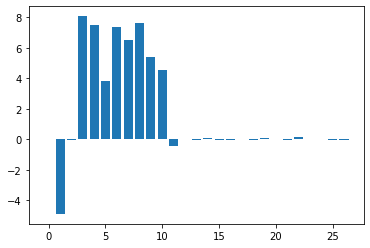

In [ ]:

# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

### Neural Network

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
# #Simple network 1
# #Appropriate architecture for the challenge

# model = Sequential()
# model.add(Dense(16, input_dim=20, activation='relu')) 
# model.add(Dropout(0.4))
# model.add(Dense(1)) 
# model.add(Activation('sigmoid')) 
# model.compile(loss='binary_crossentropy',
#               optimizer='adam',             #also try adam
#               metrics=['accuracy'])

# #model.compile(loss='mean_squared_error', optimizer='adam')
# print(model.summary())

In [ ]:
# # # Over-Complex network
# # # More complex than needed 

model = Sequential()
model.add(Dense(512, input_dim=26, activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(8))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1)) 
model.add(Activation('sigmoid'))
opt = Adam(lr=3e-4) 

model.compile(loss='binary_crossentropy',
              optimizer=opt,             #also try adam
              metrics=['accuracy'])

#model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               13824     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0

In [ ]:
#loss = model.fit(train_scaled, train_labels, epochs=20, batch_size=64, validation_split=0.2)

In [ ]:
#Fit with no early stopping or other callbacks
history = model.fit(train_scaled, train_labels ,epochs=20, validation_split=0.2) # batch_size=64,
                    #validation_data=(X_test, y_test))


Epoch 1/20
22969/22969 [==============================] - 125s 5ms/step - loss: 0.5741 - accuracy: 0.7358 - val_loss: 0.4993 - val_accuracy: 0.7732
Epoch 2/20
22969/22969 [==============================] - 124s 5ms/step - loss: 0.5383 - accuracy: 0.7644 - val_loss: 0.4971 - val_accuracy: 0.7749
Epoch 3/20
22969/22969 [==============================] - 124s 5ms/step - loss: 0.5357 - accuracy: 0.7655 - val_loss: 0.4997 - val_accuracy: 0.7756
Epoch 4/20
22969/22969 [==============================] - 125s 5ms/step - loss: 0.5336 - accuracy: 0.7674 - val_loss: 0.4963 - val_accuracy: 0.7760
Epoch 5/20
22969/22969 [==============================] - 124s 5ms/step - loss: 0.5332 - accuracy: 0.7670 - val_loss: 0.4939 - val_accuracy: 0.7770
Epoch 6/20
22969/22969 [==============================] - 124s 5ms/step - loss: 0.5325 - accuracy: 0.7674 - val_loss: 0.4945 - val_accuracy: 0.7775
Epoch 7/20
22969/22969 [==============================] - 124s 5ms/step - loss: 0.5322 - accuracy: 0.7678 - val_

In [ ]:






loss_, acc = model.evaluate(test_scaled, test_labels)
print("Accuracy = ", (acc), "%")
print("Loss = ", (loss_), "%")
# Accuracy =  79.47400212287903 % bbz kada cia taip paejo

9571/9571 [==============================] - 15s 2ms/step - loss: 0.5736 - accuracy: 0.7194
Accuracy =  0.7193763256072998 %
Loss =  0.5735553503036499 %


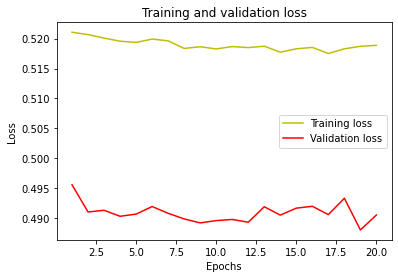

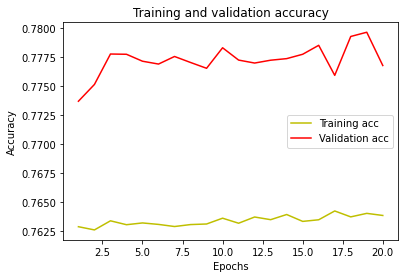

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Predicting the Test set results
y_pred = model.predict(test_scaled)
y_pred = (y_pred > 0.50)

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = metrics.accuracy_score(test_labels, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = metrics.precision_score(test_labels, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = metrics.recall_score(test_labels, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = metrics.f1_score(test_labels, y_pred)
print('F1 score: %f' % f1)

# ROC AUC
auc = metrics.roc_auc_score(test_labels, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(test_labels, y_pred)
print(matrix)

Accuracy: 0.780522
Precision: 0.735100
Recall: 0.934084
F1 score: 0.822732
ROC AUC: 0.765240
[[ 83057  56208]
 [ 11007 155978]]


In [ ]:
Accuracy: 0.719376
Precision: 0.776148
Recall: 0.682049
F1 score: 0.726063
ROC AUC: 0.723091
[[106417  32848]
 [ 53093 113892]]

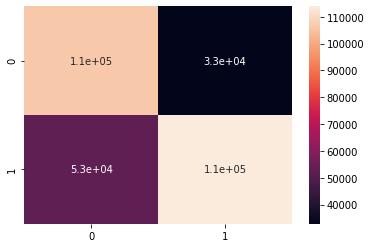

In [ ]:
sns.heatmap(matrix, annot=True)